# Deep Learning Homework: Waste classification
Authors: Gergály Anna, Mészáros Péter

## Imports and installations

Importing the necessary packages.
os, shutil for copying and renaming files.
KaggleApi, wget, zipfile to download and extact the datasets.
opencv to transform the bad images into a good format.
tensorflow to build and train the model.
sklearn, seaborn to calculate metrics and display confusion matrix.

In [ ]:
import os, shutil
from kaggle.api.kaggle_api_extended import KaggleApi

import zipfile
import numpy as np
import cv2

import tensorflow.keras as keras
from tensorflow.keras.preprocessing import image as image_utils
import tensorflow as tf

from tensorflow.keras.applications.efficientnet import EfficientNetB5
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.layers import Rescaling, GlobalAveragePooling2D, Dense, Conv2D, AveragePooling2D, MaxPool2D, Dropout, Flatten, Concatenate, Input, concatenate
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.initializers import Constant, HeNormal
from tensorflow.keras.optimizers import SGD, Adam, RMSprop

from sklearn.metrics import confusion_matrix, accuracy_score, average_precision_score,  balanced_accuracy_score, top_k_accuracy_score, f1_score, precision_score, recall_score
import seaborn as sns
import sklearn
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

In [ ]:
!pip install wget > /dev/null
import wget

## Downloading the datasets

Insert your Kaggle API keys, to download the datasets with the Kaggle API.
The first block sets the environment variables for the Kaggle API to work. More info about creating a Kaggle API Token can be found here: https://www.kaggle.com/docs/api.
The second block downloads the datasets from Kaggle.
The third block downloads a third dataset from github as a zip file, and then extracts it.

In [ ]:
os.environ['KAGGLE_USERNAME'] = 'meszarosp' #insert your api token data here
os.environ['KAGGLE_KEY'] = '683a85fabdf6cd91b3accba45dd12872'

In [ ]:
api = KaggleApi()
api.authenticate()
api.dataset_download_files('asdasdasasdas/garbage-classification', path="./garbage1", quiet=True, unzip=True)
api.dataset_download_files('mostafaabla/garbage-classification', path="./garbage2", quiet=True, unzip=True)

In [ ]:
wget.download("https://github.com/nikhilvenkatkumsetty/TrashBox/archive/refs/heads/main.zip", out="./garbage3.zip")

'./garbage3.zip'

In [ ]:
with zipfile.ZipFile("garbage3.zip", mode='r') as z:
    z.extractall("./garbage3")

In [ ]:
dataset1_directory='garbage1/Garbage classification/Garbage classification/'
dataset2_directory='garbage2/garbage_classification/'
dataset3_directory='garbage3/TrashBox-main/TrashBox_train_set'
dataset_directories = [dataset1_directory, dataset2_directory, dataset3_directory]

### Google colab drive mount

Instead of downloading the datasets every time when we use Colab, we download them from our own Drive.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp -r '/content/drive/My Drive/AIT/garbage1' .
!cp -r '/content/drive/My Drive/AIT/garbage2' .
!cp -r '/content/drive/My Drive/AIT/garbage3' .

cp: cannot stat '/content/drive/My Drive/AIT/garbage1': No such file or directory
cp: cannot stat '/content/drive/My Drive/AIT/garbage2': No such file or directory
cp: cannot stat '/content/drive/My Drive/AIT/garbage3': No such file or directory


## Preprocessing the data

Removing the last unnecessary classes from the second dataset, which can't be found in the other datasets.
Merging white-glass, brown-glass, green-glass classes into one class, named glass.

In [ ]:
removable_classes=['battery','clothes', 'biological', 'shoes']
for label in removable_classes:
    shutil.rmtree(os.path.join(dataset2_directory,label))
os.rename('garbage2/garbage_classification/brown-glass', 'garbage2/garbage_classification/glass')
glasses = [os.path.join(dataset2_directory,'white-glass'), os.path.join(dataset2_directory,'green-glass')]
for glass_directory_name in glasses:
    for filename in os.listdir(glass_directory_name):
        shutil.move(os.path.join(glass_directory_name, filename), os.path.join('garbage2/garbage_classification/glass', filename))
    os.rmdir(glass_directory_name)

Adding the extra classes to the first, second and third dataset (e-waste and medical) and adding trash to the third dataset.

In [ ]:
os.mkdir(os.path.join(dataset1_directory, 'medical'))
os.mkdir(os.path.join(dataset1_directory, 'e-waste'))
os.mkdir(os.path.join(dataset2_directory, 'e-waste'))
os.mkdir(os.path.join(dataset2_directory, 'medical'))
os.mkdir(os.path.join(dataset3_directory, 'trash'))

Many images from the third dataset were in a bad format, Tensorflow couldn't read them. The images are converted to the correct format with opencv.

The images which still turned out to be bad are also deleted.

In [ ]:
def check_images(directory):
    bad_images=[]
    class_list= os.listdir(directory)
    for image_class in class_list:
        class_path=os.path.join (directory, image_class)
        print ('processing class directory ', image_class)
        if os.path.isdir(class_path):
            file_list=os.listdir(class_path)
            for file in file_list:               
                file_path=os.path.join (class_path,file)
                if os.path.isfile(file_path):
                    try:
                        img=cv2.imread(file_path)
                        shape=img.shape
                        cv2.imwrite(file_path, img)
                    except:
                        bad_images.append(file_path)
    return bad_images

source_dir = dataset3_directory
bad_file_list=check_images(source_dir)
if len(bad_file_list) !=0:
    print('bad images:')
    for i in range (len(bad_file_list)):
        print (bad_file_list[i])
else:
    print('no bad images were found')
for bad_image in bad_file_list:
    os.remove(bad_image)

processing class directory  glass
processing class directory  metal
processing class directory  medical
processing class directory  cardboard
processing class directory  trash
processing class directory  paper
processing class directory  e-waste
processing class directory  plastic
bad images:
garbage3/TrashBox-main/TrashBox_train_set/glass/glass 1564.jpg
garbage3/TrashBox-main/TrashBox_train_set/glass/glass 1160.jpg
garbage3/TrashBox-main/TrashBox_train_set/glass/glass 1662.jpg
garbage3/TrashBox-main/TrashBox_train_set/glass/glass 2388.jpg
garbage3/TrashBox-main/TrashBox_train_set/glass/glass 1845.jpg
garbage3/TrashBox-main/TrashBox_train_set/metal/metal 1772.jpg
garbage3/TrashBox-main/TrashBox_train_set/metal/metal 2008.jpg
garbage3/TrashBox-main/TrashBox_train_set/medical/medical 1858.jpg
garbage3/TrashBox-main/TrashBox_train_set/medical/medical 1385.jpg
garbage3/TrashBox-main/TrashBox_train_set/cardboard/cardboard 2076.jpg
garbage3/TrashBox-main/TrashBox_train_set/cardboard/cardboar

## Splitting the dataset
The datasets are split in a 14:3:3 ratio.

In [ ]:
train_split = 0.7
val_split = 0.15
test_split = 0.15
class_names=['glass', 'paper', 'cardboard', 'trash', 'metal', 'plastic', 'e-waste', 'medical']
dirs = ['train', 'val', 'test']

We split the images randomly into separate directories labeled "train", "val" and "test". 

(The names are changed a bit, because in the different datasets a few images had the same name.)

In [ ]:
for dir in dirs:
  os.mkdir(dir)
  for class_name in class_names:
    os.mkdir(os.path.join(dir, class_name))

In [ ]:
np.random.seed(111)
for i in range(len(dataset_directories)):
  dataset_directory = dataset_directories[i]
  for class_name in class_names:
    for file in os.listdir(os.path.join(dataset_directory, class_name)):
      random = np.random.rand()
      file_name = os.path.splitext(file)[0]
      file_ext = os.path.splitext(file)[1]
      if random < train_split:
        shutil.copy(os.path.join(dataset_directory, class_name, file), os.path.join("./train", class_name, (file_name + str(i) + file_ext)))
      elif random < train_split + val_split:
        shutil.copy(os.path.join(dataset_directory, class_name, file), os.path.join("./val", class_name, (file_name + str(i) + file_ext )))
      else:
        shutil.copy(os.path.join(dataset_directory, class_name, file), os.path.join("./test", class_name, (file_name + str(i) + file_ext)))

We split the images randomly into separate directories labeled "train_i", "val_i" and "test_i" for each dataset. 

In [ ]:
for i in range(len(dataset_directories)):
  for dir in dirs:
    dirname = dir+ "_" + str(i)
    os.mkdir(dirname)
    for class_name in class_names:
      os.mkdir(os.path.join(dirname, class_name))

In [ ]:
np.random.seed(111)
for i in range(len(dataset_directories)):
  dataset_directory = dataset_directories[i]
  for class_name in class_names:
    for file in os.listdir(os.path.join(dataset_directory, class_name)):
      random = np.random.rand()
      file_name = os.path.splitext(file)[0]
      file_ext = os.path.splitext(file)[1]
      if random < train_split:
        shutil.copy(os.path.join(dataset_directory, class_name, file), os.path.join("./train_" + str(i), class_name, (file_name + str(i) + file_ext)))
      elif random < train_split + val_split:
        shutil.copy(os.path.join(dataset_directory, class_name, file), os.path.join("./val_" + str(i), class_name, (file_name + str(i) + file_ext )))
      else:
        shutil.copy(os.path.join(dataset_directory, class_name, file), os.path.join("./test_" + str(i), class_name, (file_name + str(i) + file_ext)))

## Reading the datasets
Setting hyperparameter variables.

The training data is augmented with an ImageDataGenerator.

In [ ]:
image_size=(256, 256)
seed=111
batch_size=32

In [ ]:
train = keras.preprocessing.image.ImageDataGenerator(
    rotation_range=90,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.1,
    zoom_range = 0.1,
    horizontal_flip = True,
    vertical_flip = True,
    rescale = 1.0/255
).flow_from_directory(
    "./train",
    image_size,
    batch_size=batch_size,
    seed = seed
)
val = keras.utils.image_dataset_from_directory(
    "./val",
    labels='inferred',
    label_mode='categorical',
    batch_size=batch_size,
    image_size=image_size,
    seed=seed,
    shuffle = False)
test = keras.utils.image_dataset_from_directory(
    "./test",
    labels='inferred',
    label_mode='categorical',
    batch_size=batch_size,
    image_size=image_size,
    seed=seed,
    shuffle = False)

Found 16174 images belonging to 8 classes.
Found 3369 files belonging to 8 classes.
Found 3528 files belonging to 8 classes.


Normalizing the datasets.

In [ ]:
normalization_layer = tf.keras.layers.Rescaling(1./255)
val = val.map(lambda x, y: (normalization_layer(x), y))
test = test.map(lambda x, y: (normalization_layer(x), y))

The datasets are read and normalized separetely.

In [ ]:
train_ = []
val_ = []
test_ = []
for i in range(3):
  train_.append(keras.preprocessing.image.ImageDataGenerator(
    rotation_range=90,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.1,
    zoom_range = 0.1,
    horizontal_flip = True,
    vertical_flip = True,
    rescale = 1.0/255
  ).flow_from_directory(
    "train_" + str(i),
    image_size,
    batch_size=batch_size,
    seed = seed
  ))
  val_.append(keras.utils.image_dataset_from_directory(
    "val_" + str(i),
    labels='inferred',
    label_mode='categorical',
    batch_size=batch_size,
    image_size=image_size,
    validation_split=None,
    seed=seed
  ))
  test_.append(keras.utils.image_dataset_from_directory(
    "test_" + str(i),
    labels='inferred',
    label_mode='categorical',
    batch_size=batch_size,
    image_size=image_size,
    validation_split=None,
    seed=seed
  ))
  val_[i] = val_[i].map(lambda x, y: (normalization_layer(x), y))
  test_[i] = test_[i].map(lambda x, y: (normalization_layer(x), y))

Found 1740 images belonging to 8 classes.
Found 399 files belonging to 8 classes.
Found 388 files belonging to 8 classes.
Found 4401 images belonging to 8 classes.
Found 945 files belonging to 8 classes.
Found 937 files belonging to 8 classes.
Found 10033 images belonging to 8 classes.
Found 2025 files belonging to 8 classes.
Found 2203 files belonging to 8 classes.


Reading the training dataset without augmentation for evaluation purposes.

In [ ]:
train_no_aug = keras.utils.image_dataset_from_directory(
    "./train",
    labels='inferred',
    class_names=['cardboard', 'e-waste', 'glass', 'medical', 'metal', 'paper', 'plastic', 'trash'],
    label_mode='categorical',
    batch_size=batch_size,
    image_size=image_size,
    seed=seed,
    shuffle = False)
train_no_aug = train_no_aug.map(lambda x, y: (normalization_layer(x), y))

Found 16174 files belonging to 8 classes.


Separating the labels from the data.

In [ ]:
test_labels = np.argmax(np.concatenate([label for image, label in test], axis=0), axis=1)

In [ ]:
val_labels = np.argmax(np.concatenate([label for image, label in val], axis=0), axis=1)

In [ ]:
train_labels = np.argmax(np.concatenate([label for image, label in train_no_aug], axis=0), axis=1)

Calculating the number of images in each category in each split.

In [ ]:
train_classes = []
val_classes = []
test_classes = []
for i in range(8):
  train_classes.append(np.count_nonzero(train_labels == i))
  val_classes.append(np.count_nonzero(val_labels == i))
  test_classes.append(np.count_nonzero(test_labels == i))

In [ ]:
train_classes = np.array(train_classes)
val_classes = np.array(val_classes)
test_classes = np.array(test_classes)

Plot displaying the ratio of the different classes in the different subsets.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


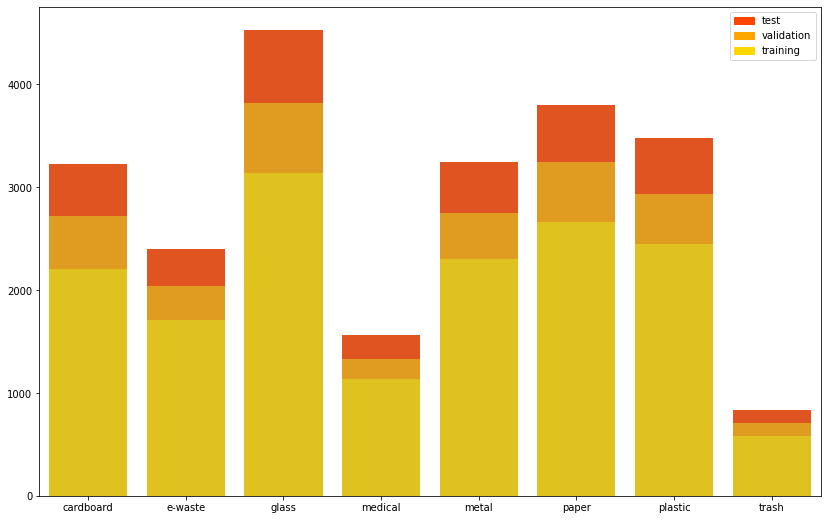

In [ ]:
plt.figure(figsize=(14, 9))


sns.barplot(["cardboard", "e-waste","glass", "medical", "metal", "paper", "plastic", "trash"], train_classes + test_classes + val_classes, x = "classes", y = "percentage", color = "orangered")
sns.barplot(["cardboard", "e-waste","glass", "medical", "metal", "paper", "plastic", "trash"], train_classes + val_classes, x = "classes", y = "percentage", color = "orange")
sns.barplot(["cardboard", "e-waste","glass", "medical", "metal", "paper", "plastic", "trash"], train_classes, x = "classes", y = "percentage", color = "gold")

top_bar = mpatches.Patch(color='orangered', label='test')
middle_bar = mpatches.Patch(color='orange', label='validation')
bottom_bar = mpatches.Patch(color='gold', label='training')

plt.legend(handles=[top_bar, middle_bar, bottom_bar])

plt.show()

## Traning the models

We chose 3 models to train.


(Evaluation is after the training and experiment.)

### First model: EffientNetB5

We chose a medium sized EfficientNet trained on image net as our first model, to ensure that it trains at a reasonable pace and also yields acceptable results. We rescaled the inputs to the range EfficientNet expects them in and added a GlobalAveragePooling layer and a Dense layer with 8 nodes to serve as our output layer. We chose a softmax activation function to go with our classification problem.

In [ ]:
base_model1 = EfficientNetB5(include_top = False, weights="imagenet", input_shape=(256, 256, 3))
base_model1.trainable = False
scale_layer = Rescaling(scale=255)
inputs = keras.Input(shape=(256, 256, 3))
x = scale_layer(inputs)
x = base_model1(x, training=False)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(8, activation='softmax')(x)
model1 = keras.Model(inputs, x)
model1.summary()

115277824/115263384 [==============================] - 5s 0us/step
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 rescaling_2 (Rescaling)     (None, 256, 256, 3)       0         
                                                                 
 efficientnetb5 (Functional)  (None, 8, 8, 2048)       28513527  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout_3 (Dropout)         (None, 2048)              0         
                                                                 
 dense_4 (Dense)             (None, 8)                 163

In [ ]:
model1.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [ ]:
es = EarlyStopping(monitor='val_categorical_accuracy', patience=5, restore_best_weights=True)

In [ ]:
model1.fit(train, validation_data=val, epochs=5, callbacks=[es], steps_per_epoch=400)

Epoch 1/5
400/400 [==============================] - 462s 1s/step - loss: 0.4043 - categorical_accuracy: 0.8655 - val_loss: 0.4066 - val_categorical_accuracy: 0.8760
Epoch 2/5
400/400 [==============================] - 439s 1s/step - loss: 0.4014 - categorical_accuracy: 0.8633 - val_loss: 0.4103 - val_categorical_accuracy: 0.8731
Epoch 3/5
400/400 [==============================] - 440s 1s/step - loss: 0.3983 - categorical_accuracy: 0.8643 - val_loss: 0.4056 - val_categorical_accuracy: 0.8769
Epoch 4/5
400/400 [==============================] - 449s 1s/step - loss: 0.3865 - categorical_accuracy: 0.8724 - val_loss: 0.4010 - val_categorical_accuracy: 0.8760
Epoch 5/5
400/400 [==============================] - 461s 1s/step - loss: 0.3854 - categorical_accuracy: 0.8690 - val_loss: 0.3992 - val_categorical_accuracy: 0.8737


In [ ]:
model1.load_weights("./drive/My Drive/AIT/checkpoints/model1_15_1")

### Second model: own model

For our second model, we decided to create our own. We added 8 convolutional layers with dropout, max and average pooling inbetween and finished it off with 3 dense layers with relu activation and HeNormal initialization and an output layer the same as our last model's.

In [ ]:
bias_initializer = Constant(0.1)
kernel_initializer = HeNormal()
dropout_rate = 0.4

inputs = Input(shape=(256, 256, 3))
branch_1 = Conv2D(filters=10, kernel_size=(5,5),padding="same", kernel_initializer=kernel_initializer, bias_initializer=bias_initializer)(inputs)
branch_1=(Conv2D(filters=10, kernel_size=(5,5),padding="same", kernel_initializer=kernel_initializer, bias_initializer=bias_initializer))(branch_1)
branch_1=(MaxPool2D())(branch_1)
branch_1=(Dropout(rate=dropout_rate))(branch_1)
branch_1=(Conv2D(filters=10, kernel_size=(3,3),padding="same", kernel_initializer=kernel_initializer, bias_initializer=bias_initializer))(branch_1)
branch_1=(Conv2D(filters=10, kernel_size=(3,3),padding="same", activation='relu', kernel_initializer=kernel_initializer, bias_initializer=bias_initializer))(branch_1)
branch_1=(MaxPool2D())(branch_1)

branch_1=Conv2D(filters=5, kernel_size=(3,3),padding="same", kernel_initializer=kernel_initializer, bias_initializer=bias_initializer)(branch_1)
branch_1=(Conv2D(filters=5, kernel_size=(3,3),padding="same", kernel_initializer=kernel_initializer, bias_initializer=bias_initializer))(branch_1)
branch_1=(AveragePooling2D(pool_size=(2, 2), strides=2))(branch_1)

branch_2=(Dropout(rate=dropout_rate))(branch_1)

branch_1=Flatten()(branch_1)

branch_2=(Conv2D(filters=5, kernel_size=(3,3),padding="same", kernel_initializer=kernel_initializer, bias_initializer=bias_initializer))(branch_2)
branch_2=(Conv2D(filters=5, kernel_size=(3,3),padding="same", kernel_initializer=kernel_initializer, bias_initializer=bias_initializer))(branch_2)
branch_2=(AveragePooling2D())(branch_2)

branch_2=Flatten()(branch_2)

concat = concatenate([branch_1, branch_2])


end=(Dense(512, activation='relu', kernel_initializer=kernel_initializer, bias_initializer=bias_initializer))(concat)
end=(Dense(512, activation='relu', kernel_initializer=kernel_initializer, bias_initializer=bias_initializer))(end)
end=(Dense(512, activation='relu', kernel_initializer=kernel_initializer, bias_initializer=bias_initializer))(end)
end=(Dropout(rate=dropout_rate)) (end)
output=(Dense(8, activation='softmax'))(end)

model2 = Model(inputs = inputs, outputs=output)

model2.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy', 'accuracy'])
model2.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 10  760         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 256, 256, 10  2510        ['conv2d[0][0]']                 
                                )                                                             

In [ ]:
es = EarlyStopping(monitor='val_categorical_accuracy', patience=8, restore_best_weights=True)
save_weights = ModelCheckpoint("./drive/My Drive/AIT/model2_2_Adam_1", monitor='val_categorical_accuracy', verbose=1,
    save_best_only=True, mode='max', save_weights_only=True, save_freq='epoch')

In [ ]:
model2.fit(train, validation_data=val, epochs=10, callbacks=[es, save_weights], steps_per_epoch=400)

Epoch 1/10
400/400 [==============================] - ETA: 0s - loss: 1.6030 - categorical_accuracy: 0.4067 - accuracy: 0.4067
Epoch 1: val_categorical_accuracy did not improve from 0.35322
400/400 [==============================] - 282s 704ms/step - loss: 1.6030 - categorical_accuracy: 0.4067 - accuracy: 0.4067 - val_loss: 1.8038 - val_categorical_accuracy: 0.3455 - val_accuracy: 0.3455
Epoch 2/10
400/400 [==============================] - ETA: 0s - loss: 1.5961 - categorical_accuracy: 0.4185 - accuracy: 0.4185
Epoch 2: val_categorical_accuracy improved from 0.35322 to 0.39656, saving model to ./drive/My Drive/AIT/model2_2_Adam_1
400/400 [==============================] - 281s 701ms/step - loss: 1.5961 - categorical_accuracy: 0.4185 - accuracy: 0.4185 - val_loss: 1.6687 - val_categorical_accuracy: 0.3966 - val_accuracy: 0.3966
Epoch 3/10
400/400 [==============================] - ETA: 0s - loss: 1.5840 - categorical_accuracy: 0.4132 - accuracy: 0.4132
Epoch 3: val_categorical_accuracy

In [ ]:
model2.load_weights("./drive/My Drive/AIT/model2_2_Adam_1")

In [ ]:
bias_initializer = Constant(0.1)
kernel_initializer = HeNormal()
dropout_rate = 0.4

inputs = Input(shape=(256, 256, 3))

branch_0 = Conv2D(filters=20, kernel_size=(5, 5), strides=2, padding="same", kernel_initializer=kernel_initializer, bias_initializer=bias_initializer)(inputs)
branch_0 = Conv2D(filters=20, kernel_size=(5, 5), strides=2, padding="same", kernel_initializer=kernel_initializer, bias_initializer=bias_initializer)(branch_0)
branch_0=(MaxPool2D())(branch_0)
branch_0=Dropout(dropout_rate)(branch_0)
branch_0 = Conv2D(filters=10, kernel_size=(3, 3), padding="same", kernel_initializer=kernel_initializer, bias_initializer=bias_initializer)(branch_0)
branch_0 = Conv2D(filters=5, kernel_size=(3, 3), padding="same", kernel_initializer=kernel_initializer, bias_initializer=bias_initializer)(branch_0)
branch_0=MaxPool2D(pool_size=3, strides=3)(branch_0)
branch_0=Flatten()(branch_0)

branch_1 = Conv2D(filters=10, kernel_size=(5,5),padding="same", kernel_initializer=kernel_initializer, bias_initializer=bias_initializer)(inputs)
branch_1=(Conv2D(filters=10, kernel_size=(5,5),padding="same", kernel_initializer=kernel_initializer, bias_initializer=bias_initializer))(branch_1)
branch_1=(MaxPool2D())(branch_1)
branch_1=(Dropout(rate=dropout_rate))(branch_1)
branch_1=(Conv2D(filters=10, kernel_size=(3,3),padding="same", kernel_initializer=kernel_initializer, bias_initializer=bias_initializer))(branch_1)
branch_1=(Conv2D(filters=10, kernel_size=(3,3),padding="same", activation='relu', kernel_initializer=kernel_initializer, bias_initializer=bias_initializer))(branch_1)
branch_1=(MaxPool2D())(branch_1)
branch_1=Conv2D(filters=5, kernel_size=(3,3),padding="same", kernel_initializer=kernel_initializer, bias_initializer=bias_initializer)(branch_1)
branch_1=(Conv2D(filters=5, kernel_size=(3,3),padding="same", kernel_initializer=kernel_initializer, bias_initializer=bias_initializer))(branch_1)
branch_1=AveragePooling2D(pool_size=(3, 3), strides=3)(branch_1)

branch_2=(Dropout(rate=dropout_rate))(branch_1)

branch_1=Flatten()(branch_1)

branch_2=(Conv2D(filters=5, kernel_size=(3,3),padding="same", kernel_initializer=kernel_initializer, bias_initializer=bias_initializer))(branch_2)
branch_2=(Conv2D(filters=5, kernel_size=(3,3),padding="same", kernel_initializer=kernel_initializer, bias_initializer=bias_initializer))(branch_2)
branch_2=(AveragePooling2D())(branch_2)

branch_2=Flatten()(branch_2)

print(branch_1.shape)
print(branch_2.shape)

concat = concatenate([branch_0, branch_1, branch_2])

print(concat)


end=(Dense(512, activation='relu', kernel_initializer=kernel_initializer, bias_initializer=bias_initializer))(concat)
end=(Dense(512, activation='relu', kernel_initializer=kernel_initializer, bias_initializer=bias_initializer))(end)
end=(Dense(512, activation='relu', kernel_initializer=kernel_initializer, bias_initializer=bias_initializer))(end)
end=(Dropout(rate=dropout_rate)) (end)
output=(Dense(8, activation='softmax'))(end)

model2 = Model(inputs = inputs, outputs=output)

model2.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy', 'accuracy'])
model2.summary()

(None, 2205)
(None, 500)
KerasTensor(type_spec=TensorSpec(shape=(None, 3205), dtype=tf.float32, name=None), name='concatenate_1/concat:0', description="created by layer 'concatenate_1'")
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_12 (Conv2D)             (None, 256, 256, 10  760         ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 con

In [ ]:
es = EarlyStopping(monitor='val_categorical_accuracy', patience=8, restore_best_weights=True)
save_weights = ModelCheckpoint("./drive/My Drive/AIT/model2_3_Adam_2", monitor='val_categorical_accuracy', verbose=1,
    save_best_only=True, mode='max', save_weights_only=True, save_freq='epoch')

In [ ]:
model2.fit(train, validation_data=val, epochs=40, callbacks=[es, save_weights], steps_per_epoch=200)

Epoch 1/40
200/200 [==============================] - ETA: 0s - loss: 3.4771 - categorical_accuracy: 0.1990 - accuracy: 0.1990
Epoch 1: val_categorical_accuracy improved from -inf to 0.22559, saving model to ./drive/My Drive/AIT/model2_3_Adam_2
200/200 [==============================] - 159s 733ms/step - loss: 3.4771 - categorical_accuracy: 0.1990 - accuracy: 0.1990 - val_loss: 2.2073 - val_categorical_accuracy: 0.2256 - val_accuracy: 0.2256
Epoch 2/40
200/200 [==============================] - ETA: 0s - loss: 1.8646 - categorical_accuracy: 0.2802 - accuracy: 0.2802
Epoch 2: val_categorical_accuracy improved from 0.22559 to 0.24340, saving model to ./drive/My Drive/AIT/model2_3_Adam_2
200/200 [==============================] - 149s 744ms/step - loss: 1.8646 - categorical_accuracy: 0.2802 - accuracy: 0.2802 - val_loss: 2.0408 - val_categorical_accuracy: 0.2434 - val_accuracy: 0.2434
Epoch 3/40
200/200 [==============================] - ETA: 0s - loss: 1.8233 - categorical_accuracy: 0.29

In [ ]:
model2.load_weights("./drive/My Drive/AIT/model2_3_Adam_2")

### Third model: MobileNetV2

For the third model, we chose a smaller one. The MobileNetV2 has 3.5M trainable parameters, which is almost the tenth of the EfficientNetB5's, which is about 30.6M. This model has a very low inferencte time. We expect similar or not so much worse results.  We rescaled the inputs to the range MobilenetV2 expects them in and added a GlobalAveragePooling layer and a Dense layer with 8 nodes to serve as our output layer. We chose a softmax activation function to go with our classification problem.

In [ ]:
base_model3 = MobileNetV2(input_shape=(256, 256, 3), include_top=False, weights="imagenet")
base_model3.trainable = False
scale_layer = Rescaling(scale=2, offset = -1)
inputs = keras.Input(shape=(256, 256, 3))
x = scale_layer(inputs)
x = base_model3(x, training=False)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(8, activation='softmax')(x)
model3 = keras.Model(inputs, x)
model3.summary()

Model: "model_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_30 (InputLayer)       [(None, 256, 256, 3)]     0         
                                                                 
 rescaling_18 (Rescaling)    (None, 256, 256, 3)       0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 8, 8, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_14  (None, 1280)             0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dropout_14 (Dropout)        (None, 1280)              0         
                                                                 
 dense_14 (Dense)            (None, 8)                 102

In [ ]:
model3.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [ ]:
es = EarlyStopping(monitor='val_categorical_accuracy', patience=5, restore_best_weights=True)
save_weights = ModelCheckpoint("./drive/My Drive/AIT/model3checkpoints", monitor='val_categorical_accuracy', verbose=1,
    save_best_only=True, mode='max', save_weights_only=True, save_freq='epoch')

In [ ]:
model3.fit(train, validation_data=val, epochs=10, callbacks=[es, save_weights], steps_per_epoch=400)

#### Fine-tuning


In [ ]:
base_model3.training = True

In [ ]:
model3.compile(optimizer=RMSprop(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [ ]:
es = EarlyStopping(monitor='val_categorical_accuracy', patience=5, restore_best_weights=True)
save_weights = ModelCheckpoint("./drive/My Drive/AIT/model3checkpoints", monitor='val_categorical_accuracy', verbose=1,
    save_best_only=True, mode='max', save_weights_only=True, save_freq='epoch')

In [ ]:
model3.fit(train, validation_data=val, epochs=10, callbacks=[es, save_weights], steps_per_epoch=400)

Epoch 1/10
400/400 [==============================] - ETA: 0s - loss: 0.7143 - categorical_accuracy: 0.7566
Epoch 1: val_categorical_accuracy improved from -inf to 0.82012, saving model to ./drive/My Drive/AIT/model3checkpoints
400/400 [==============================] - 334s 828ms/step - loss: 0.7143 - categorical_accuracy: 0.7566 - val_loss: 0.5337 - val_categorical_accuracy: 0.8201
Epoch 2/10
400/400 [==============================] - ETA: 0s - loss: 0.7082 - categorical_accuracy: 0.7588
Epoch 2: val_categorical_accuracy did not improve from 0.82012
400/400 [==============================] - 321s 802ms/step - loss: 0.7082 - categorical_accuracy: 0.7588 - val_loss: 0.5307 - val_categorical_accuracy: 0.8198
Epoch 3/10
400/400 [==============================] - ETA: 0s - loss: 0.6928 - categorical_accuracy: 0.7608
Epoch 3: val_categorical_accuracy improved from 0.82012 to 0.82458, saving model to ./drive/My Drive/AIT/model3checkpoints
400/400 [==============================] - 320s 801m

## Experiment

Training the first model on the seond dataset and after that training it on the third one.

In [ ]:
base_model1 = EfficientNetB5(include_top = False, weights="imagenet", input_shape=(256, 256, 3))
base_model1.trainable = False
scale_layer = Rescaling(scale=255)
inputs = keras.Input(shape=(256, 256, 3))
x = scale_layer(inputs)
x = base_model1(x, training=False)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(8, activation='softmax')(x)
experiment1 = keras.Model(inputs, x)
experiment1.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 256, 256, 3)]     0         
                                                                 
 rescaling_10 (Rescaling)    (None, 256, 256, 3)       0         
                                                                 
 efficientnetb5 (Functional)  (None, 8, 8, 2048)       28513527  
                                                                 
 global_average_pooling2d_4   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_4 (Dropout)         (None, 2048)              0         
                                                                 
 dense_4 (Dense)             (None, 8)                 16392     
                                                           

In [ ]:
experiment1.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [ ]:
es = EarlyStopping(monitor='val_categorical_accuracy', patience=5, restore_best_weights=True)
save_weights = ModelCheckpoint("./drive/My Drive/AIT/experiment1checkpoints", monitor='val_categorical_accuracy', verbose=1,
    save_best_only=True, mode='max', save_weights_only=True, save_freq='epoch')

In [ ]:
experiment1.load_weights("./drive/My Drive/AIT/experiment1checkpoints")

In [ ]:
experiment1.fit(train_[1], validation_data=val_[1], epochs=20, callbacks=[es, save_weights], steps_per_epoch=100)

Epoch 1/20
100/100 [==============================] - ETA: 0s - loss: 0.8584 - categorical_accuracy: 0.7416
Epoch 1: val_categorical_accuracy improved from -inf to 0.88995, saving model to ./drive/My Drive/AIT/experiment1checkpoints
100/100 [==============================] - 115s 971ms/step - loss: 0.8584 - categorical_accuracy: 0.7416 - val_loss: 0.4261 - val_categorical_accuracy: 0.8899
Epoch 2/20
100/100 [==============================] - ETA: 0s - loss: 0.4381 - categorical_accuracy: 0.8641
Epoch 2: val_categorical_accuracy improved from 0.88995 to 0.91005, saving model to ./drive/My Drive/AIT/experiment1checkpoints
100/100 [==============================] - 93s 926ms/step - loss: 0.4381 - categorical_accuracy: 0.8641 - val_loss: 0.3328 - val_categorical_accuracy: 0.9101
Epoch 3/20
100/100 [==============================] - ETA: 0s - loss: 0.3610 - categorical_accuracy: 0.8823
Epoch 3: val_categorical_accuracy improved from 0.91005 to 0.91958, saving model to ./drive/My Drive/AIT/e

In [ ]:
save_weights = ModelCheckpoint("./drive/My Drive/AIT/experiment1checkpoints_2", monitor='val_categorical_accuracy', verbose=1,
    save_best_only=True, mode='max', save_weights_only=True, save_freq='epoch')

In [ ]:
experiment1.fit(train_[2], validation_data=val_[2], epochs=20, callbacks=[es, save_weights], steps_per_epoch=200)

Epoch 1/20
200/200 [==============================] - ETA: 0s - loss: 0.8843 - categorical_accuracy: 0.7161
Epoch 1: val_categorical_accuracy improved from -inf to 0.82716, saving model to ./drive/My Drive/AIT/experiment1checkpoints_2
200/200 [==============================] - 296s 1s/step - loss: 0.8843 - categorical_accuracy: 0.7161 - val_loss: 0.5184 - val_categorical_accuracy: 0.8272
Epoch 2/20
200/200 [==============================] - ETA: 0s - loss: 0.6125 - categorical_accuracy: 0.7933
Epoch 2: val_categorical_accuracy improved from 0.82716 to 0.84000, saving model to ./drive/My Drive/AIT/experiment1checkpoints_2
200/200 [==============================] - 269s 1s/step - loss: 0.6125 - categorical_accuracy: 0.7933 - val_loss: 0.4695 - val_categorical_accuracy: 0.8400
Epoch 3/20
200/200 [==============================] - ETA: 0s - loss: 0.5715 - categorical_accuracy: 0.8014
Epoch 3: val_categorical_accuracy improved from 0.84000 to 0.84198, saving model to ./drive/My Drive/AIT/ex

In [ ]:
experiment1.evaluate(test_[0])

13/13 [==============================] - 9s 592ms/step - loss: 1.2650 - categorical_accuracy: 0.7448


[1.264991283416748, 0.7448453903198242]

In [ ]:
experiment1.evaluate(test_[1])

30/30 [==============================] - 17s 538ms/step - loss: 1.0057 - categorical_accuracy: 0.7417


[1.0057282447814941, 0.7417289018630981]

In [ ]:
experiment1.evaluate(test_[2])

69/69 [==============================] - 43s 581ms/step - loss: 0.4086 - categorical_accuracy: 0.8697


[0.40856829285621643, 0.8697230815887451]

## Evaluation

In [ ]:
def calculate_eval_metrics(model, dataset, labels = None):
  if labels is None:
    labels = np.argmax(np.concatenate([label for image, label in dataset], axis=0), axis=1)
  preds = model.predict(dataset)
  prediction_category = np.argmax(preds, axis=1)
  result = dict()

  result['accuracy'] = accuracy_score(labels, prediction_category)
  result['balanced_accuracy'] = balanced_accuracy_score(labels, prediction_category)
  result['f1'] = sklearn.metrics.f1_score(labels, prediction_category, average='weighted')
  result['precision'] = precision_score(labels, prediction_category, average='weighted')
  result['recall'] = recall_score(labels, prediction_category, average='weighted')
  for i in range(8):
    result['f1_' + str(i)] = sklearn.metrics.f1_score(labels, prediction_category, labels=[i], average='macro')
    result['precision_' + str(i)] = sklearn.metrics.f1_score(labels, prediction_category, labels=[i], average='macro')
    result['recall_' + str(i)] = sklearn.metrics.f1_score(labels, prediction_category, labels=[i], average='macro')
  result['top_2'] = top_k_accuracy_score(labels, preds, k=2)
  result['top_3'] = top_k_accuracy_score(labels, preds, k=3)
  return result

Extracting the labels from the datasets.

In [ ]:
train_no_aug = keras.utils.image_dataset_from_directory(
    "./train",
    labels='inferred',
    class_names=['cardboard', 'e-waste', 'glass', 'medical', 'metal', 'paper', 'plastic', 'trash'],
    label_mode='categorical',
    batch_size=batch_size,
    image_size=image_size,
    seed=seed,
    shuffle = False)
train_no_aug = train_no_aug.map(lambda x, y: (normalization_layer(x), y))

Found 16174 files belonging to 8 classes.


First model

In [ ]:
model1_test_metrics = calculate_eval_metrics(model1, test, test_labels)
model1_val_metrics = calculate_eval_metrics(model1, val, val_labels)
model1_train_metrics = calculate_eval_metrics(model1, train_no_aug, train_labels)

In [ ]:
model1_test_metrics, model1_val_metrics, model1_train_metrics

({'accuracy': 0.8990929705215419,
  'balanced_accuracy': 0.8916385238918945,
  'f1': 0.8992515669589416,
  'f1_0': 0.9298597194388778,
  'f1_1': 0.9282700421940928,
  'f1_2': 0.9214437367303608,
  'f1_3': 0.8755186721991701,
  'f1_4': 0.8829365079365079,
  'f1_5': 0.8916741271262308,
  'f1_6': 0.8685185185185185,
  'f1_7': 0.8421052631578947,
  'precision': 0.8997751252017229,
  'precision_0': 0.9298597194388778,
  'precision_1': 0.9282700421940928,
  'precision_2': 0.9214437367303608,
  'precision_3': 0.8755186721991701,
  'precision_4': 0.8829365079365079,
  'precision_5': 0.8916741271262308,
  'precision_6': 0.8685185185185185,
  'precision_7': 0.8421052631578947,
  'recall': 0.8990929705215419,
  'recall_0': 0.9298597194388778,
  'recall_1': 0.9282700421940928,
  'recall_2': 0.9214437367303608,
  'recall_3': 0.8755186721991701,
  'recall_4': 0.8829365079365079,
  'recall_5': 0.8916741271262308,
  'recall_6': 0.8685185185185185,
  'recall_7': 0.8421052631578947,
  'top_2': 0.9640022

In [ ]:
preds = model1.predict(test)

In [ ]:
prediction = np.argmax(preds, axis=1)

conf=confusion_matrix(test_labels, prediction)

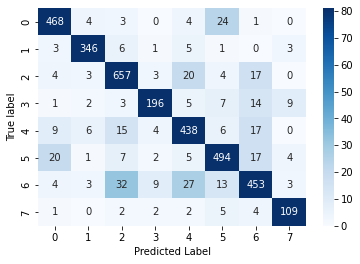

In [ ]:
ax = sns.heatmap(conf, annot=True, fmt='d', cmap='Blues', vmax = 81) 
ax.set(xlabel='Predicted Label',
       ylabel='True label');

Second model.

In [ ]:
model2_test_metrics = calculate_eval_metrics(model2, test, test_labels)
model2_val_metrics = calculate_eval_metrics(model2, val, val_labels)
model2_train_metrics = calculate_eval_metrics(model2, train_no_aug, train_labels)

In [ ]:
model2_test_metrics, model2_val_metrics, model2_train_metrics

({'accuracy': 0.39880952380952384,
  'balanced_accuracy': 0.3490714429146722,
  'f1': 0.3819561300781615,
  'f1_0': 0.5486284289276808,
  'f1_1': 0.4264264264264264,
  'f1_2': 0.5215189873417722,
  'f1_3': 0.278118609406953,
  'f1_4': 0.276595744680851,
  'f1_5': 0.2510460251046025,
  'f1_6': 0.3642553191489361,
  'f1_7': 0.05673758865248227,
  'precision': 0.3831929640637054,
  'precision_0': 0.5486284289276808,
  'precision_1': 0.4264264264264264,
  'precision_2': 0.5215189873417722,
  'precision_3': 0.278118609406953,
  'precision_4': 0.276595744680851,
  'precision_5': 0.2510460251046025,
  'precision_6': 0.3642553191489361,
  'precision_7': 0.05673758865248227,
  'recall': 0.39880952380952384,
  'recall_0': 0.5486284289276808,
  'recall_1': 0.4264264264264264,
  'recall_2': 0.5215189873417722,
  'recall_3': 0.278118609406953,
  'recall_4': 0.276595744680851,
  'recall_5': 0.2510460251046025,
  'recall_6': 0.3642553191489361,
  'recall_7': 0.05673758865248227,
  'top_2': 0.59552154

In [ ]:
preds = model2.predict(test)

In [ ]:
prediction = np.argmax(preds, axis=1)

conf=confusion_matrix(test_labels, prediction)

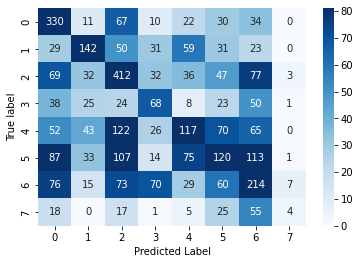

In [ ]:
ax = sns.heatmap(conf, annot=True, fmt='d', cmap='Blues', vmax = 81) 
ax.set(xlabel='Predicted Label',
       ylabel='True label');

Second model, second approach (three branches).

In [ ]:
model2_test_metrics = calculate_eval_metrics(model2, test, test_labels)
model2_val_metrics = calculate_eval_metrics(model2, val, val_labels)
model2_train_metrics = calculate_eval_metrics(model2, train_no_aug, train_labels)

In [ ]:
model2_test_metrics, model2_val_metrics, model2_train_metrics

({'accuracy': 0.35487528344671204,
  'balanced_accuracy': 0.29696859086527744,
  'f1': 0.326024233481223,
  'f1_0': 0.5102586975914362,
  'f1_1': 0.21141649048625794,
  'f1_2': 0.43197458973001585,
  'f1_3': 0.23310023310023312,
  'f1_4': 0.20933521923620932,
  'f1_5': 0.22746781115879824,
  'f1_6': 0.39854014598540144,
  'f1_7': 0.07407407407407407,
  'precision': 0.3618512259479963,
  'precision_0': 0.5102586975914362,
  'precision_1': 0.21141649048625794,
  'precision_2': 0.43197458973001585,
  'precision_3': 0.23310023310023312,
  'precision_4': 0.20933521923620932,
  'precision_5': 0.22746781115879824,
  'precision_6': 0.39854014598540144,
  'precision_7': 0.07407407407407407,
  'recall': 0.35487528344671204,
  'recall_0': 0.5102586975914362,
  'recall_1': 0.21141649048625794,
  'recall_2': 0.43197458973001585,
  'recall_3': 0.23310023310023312,
  'recall_4': 0.20933521923620932,
  'recall_5': 0.22746781115879824,
  'recall_6': 0.39854014598540144,
  'recall_7': 0.0740740740740740

In [ ]:
preds = model2.predict(test)

In [ ]:
prediction = np.argmax(preds, axis=1)

conf=confusion_matrix(test_labels, prediction)

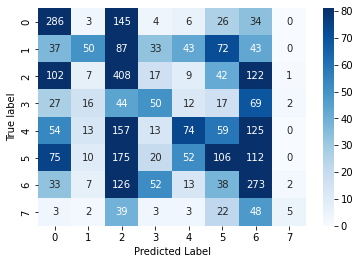

In [ ]:
ax = sns.heatmap(conf, annot=True, fmt='d', cmap='Blues', vmax = 81) 
ax.set(xlabel='Predicted Label',
       ylabel='True label');

Third model.

In [ ]:
model3_test_metrics = calculate_eval_metrics(model3, test, test_labels)
model3_val_metrics = calculate_eval_metrics(model3, val, val_labels)
model3_train_metrics = calculate_eval_metrics(model3, train_no_aug, train_labels)

In [ ]:
model3_test_metrics, model3_val_metrics, model3_train_metrics

({'accuracy': 0.8310657596371882,
  'balanced_accuracy': 0.8142557360875566,
  'f1': 0.831000023109013,
  'f1_0': 0.899492385786802,
  'f1_1': 0.8915662650602408,
  'f1_2': 0.8649405178446465,
  'f1_3': 0.7925311203319502,
  'f1_4': 0.7903525046382189,
  'f1_5': 0.826086956521739,
  'f1_6': 0.7568075117370893,
  'f1_7': 0.7641509433962264,
  'precision': 0.8350289456856186,
  'precision_0': 0.899492385786802,
  'precision_1': 0.8915662650602408,
  'precision_2': 0.8649405178446465,
  'precision_3': 0.7925311203319502,
  'precision_4': 0.7903525046382189,
  'precision_5': 0.826086956521739,
  'precision_6': 0.7568075117370893,
  'precision_7': 0.7641509433962264,
  'recall': 0.8310657596371882,
  'recall_0': 0.899492385786802,
  'recall_1': 0.8915662650602408,
  'recall_2': 0.8649405178446465,
  'recall_3': 0.7925311203319502,
  'recall_4': 0.7903525046382189,
  'recall_5': 0.826086956521739,
  'recall_6': 0.7568075117370893,
  'recall_7': 0.7641509433962264,
  'top_2': 0.94217687074829

In [ ]:
preds = model3.predict(test)

In [ ]:
prediction = np.argmax(preds, axis=1)

conf=confusion_matrix(test_labels, prediction)

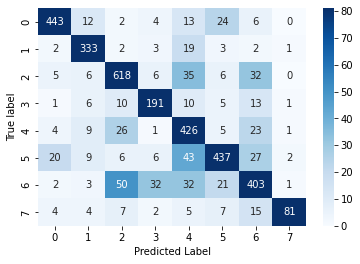

In [ ]:
ax = sns.heatmap(conf, annot=True, fmt='d', cmap='Blues', vmax = 81) 
ax.set(xlabel='Predicted Label',
       ylabel='True label');